# Sentiment Analysis Assignment

## Laoutaris Nikolaos

### Programming for Data Science 2024-2025

I am submitting this notebook in place of a report because that's what notebooks are for. In the abscence of strict guidelines, I allowed myself some informality. I hope this assignment makes for an interesting read (all things considered). Without further ado, let's begin with you know what.

In [6]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict

pd.set_option('display.max_colwidth', None)

## Loading the data

Let's load the data into a single dataframe. No need to deal with pre-separated train and test data.

In [9]:
dftrain = pd.read_csv("train.csv", encoding='latin1')
dftest = pd.read_csv("test.csv", encoding='latin1')
df = pd.concat([dftrain, dftest])
df # Sneak peek

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...,...
4810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Okay now we know we're up against. Very interesting info but for this assignment we don't need all of it. Let's just keep what's relevant for us right now.

In [11]:
df.drop(columns=[col for col in df.columns if col not in ['text', 'sentiment']], inplace=True)

Starting with the usual suspect: missing values.

In [13]:
df.isnull().sum()

text         1282
sentiment    1281
dtype: int64

Seeing as there's no way to impute missing text, we'll drop them all.

In [15]:
df.dropna(inplace=True)

## Data Preprocessing

The dreadful part. We will define a preprocessing function and apply it to the whole dataset.

In [18]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stop.update({'u', 'x', 'ur', 'im', }) # Adding my own from experience

def preprocessor(text):
    text = text.lower() # Convert all to lowercase
    text = re.sub(r'http\S+|www\S+', ' ', text) # Remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text) # Remove non-alphanumeric characters (keep spaces though)

    # Remove stopwords
    ret_text = ""
    for word in text.split():
        if word not in stop:
            ret_text += word + " "
            
    ret_text = re.sub(r'\s+', ' ', ret_text).strip() # Remove extra whitespace

    if len(ret_text) == 0: # Check if we cleaned it dead to drop it later
        ret_text = np.nan
        
    return ret_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicklamda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's keep the original text, just in case, and apply the cleaning.

In [20]:
df['dirty_text'] = df['text'].copy()
df['text'] = df['dirty_text'].apply(preprocessor)
df.isnull().sum()

text          105
sentiment       0
dirty_text      0
dtype: int64

That's not too big of a loss. Let's drop them and see the beautiful result.

In [22]:
df.dropna(inplace=True) 
df[['dirty_text', 'text']].sample(n=10, random_state=42)

,dirty_text,text
2165,fantastic day in the AZ sun,fantastic day az sun
19740,"_x hah, well at least we are not saying; tory is a fatty watty",hah well least saying tory fatty watty
3893,"1st- TY to those who follow back. 2nd - grrr to those who don`t, cuz it messes up being able to follow others u want to when ur at 2000+",st ty follow back nd grrr cuz messes able follow others want
22762,"Working late at night on a Dell notebook, Dell`s quality has gone down hill, warrenty service sucks too, poor people buy a Mac instead",working late night dell notebook dell quality gone hill warrenty service sucks poor people buy mac instead
11514,My pleasure. Hear Kelli has new project! #followfriday,pleasure hear kelli new project followfriday
229,sorry for my lack of tweets ive been buzy. new vid this saturday!!,sorry lack tweets ive buzy new vid saturday
9667,thanx for showin luv,thanx showin luv
20593,just watching ncis complete first season,watching ncis complete first season
21305,I was rooting for Betty.,rooting betty
2810,"Ooo showing of your French skills!! lol Things good over here. Lovely weather, so should be outside How`s u?",ooo showing french skills lol things good lovely weather outside


## Exploratory Data Analysis

Let's first just check to see all sentiments are correctly labeled and their value counts.

In [25]:
df['sentiment'].value_counts()

sentiment
neutral     12450
positive     9682
negative     8777
Name: count, dtype: int64

Too many neutral sentiments are to be expected, but they don't offer much information for our analysis. Regardless, everything looks to be in order. Let's move on to visualizing the data we have, trying to extract some insights. We start with my favourite, word clouds.

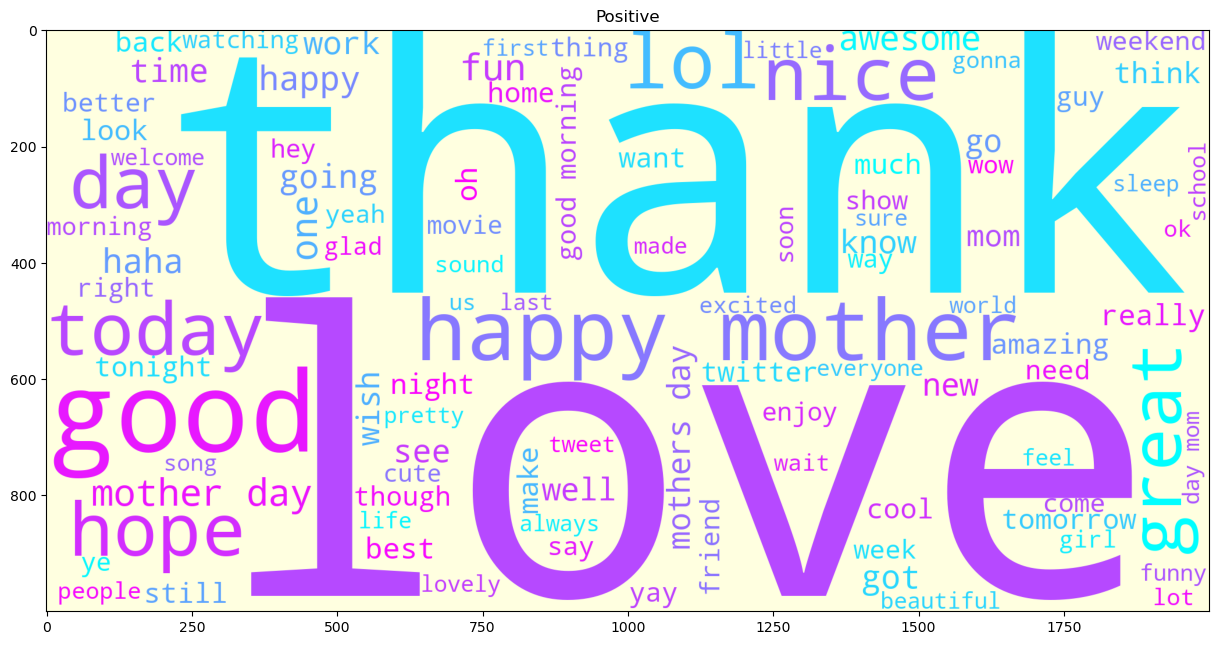

In [27]:
# For positive sentiments
WordCloud()
positive_df = df[df['sentiment']=='positive']
positive_list = positive_df['text'].tolist()
positive_string = " ".join(positive_list)
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='lightyellow',
                      colormap = 'cool',
                      max_words = 100).generate(positive_string)

plt.figure(figsize=(15,9))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

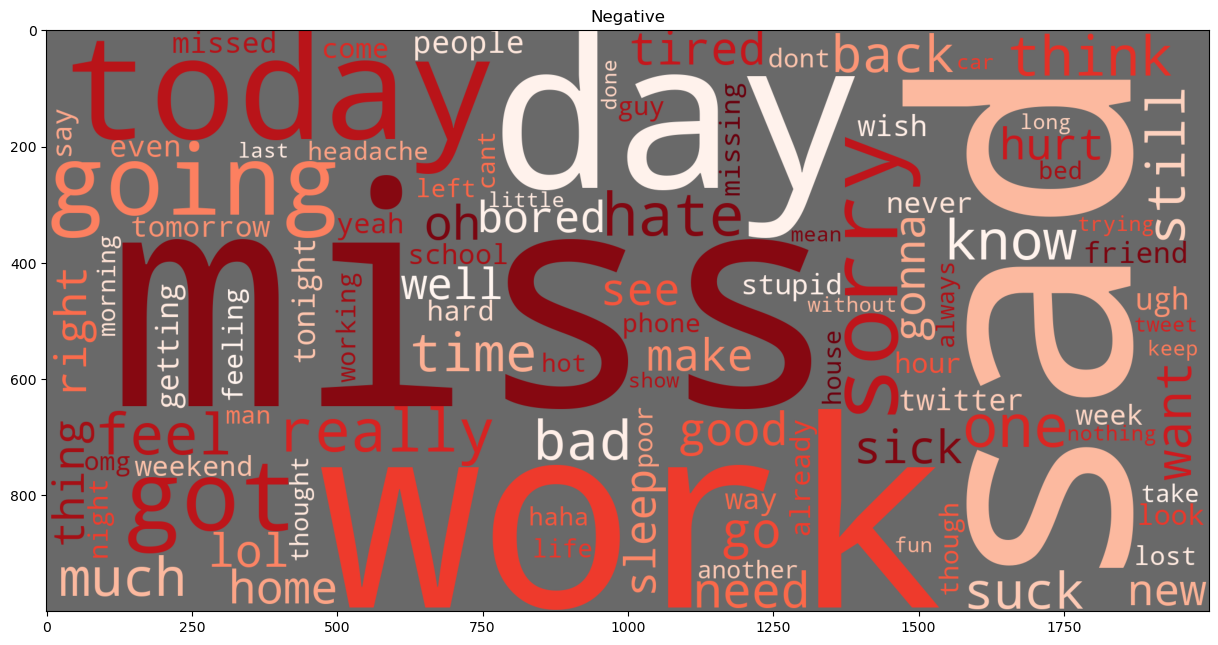

In [28]:
# For negative sentiments
WordCloud()
negative_df = df[df['sentiment']=='negative']
negative_list = negative_df['text'].tolist()
negative_string = " ".join(negative_list)
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='dimgray',
                      colormap = 'Reds',
                      max_words = 100).generate(negative_string)

plt.figure(figsize=(15,9))
plt.imshow(wordcloud)
plt.title("Negative")
plt.show()

What if there is a correlation between text length and sentiment? We can inspect this with a v-plot (violin plot).

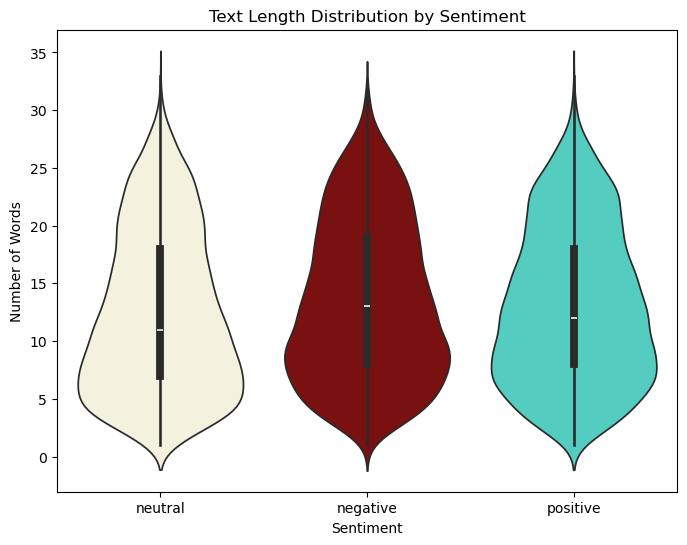

In [30]:
df['text_length'] = df['dirty_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,6))
sns.violinplot(x='sentiment', y='text_length', data=df, hue='sentiment', palette={'neutral':'beige', 'positive':'turquoise', 'negative':'darkred'})
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

## Sentiment Analysis

The first model we'll try is TextBlob. We'll save its predictions in a new column to compare them later.

In [33]:
def predictTextBlob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return pd.Series([sentiment, polarity])

df[['TextBlob', 'TextBlob polarity']] = df['text'].apply(predictTextBlob)
df['TextBlob'].value_counts()

TextBlob
positive    14042
neutral     11058
negative     5809
Name: count, dtype: int64

Why not also run VADER to see if it's better?

In [35]:
anakin = SentimentIntensityAnalyzer()
def predictVADER(text):
    polarity = anakin.polarity_scores(text)['compound']
    if polarity >= 0.05:
        sentiment = 'positive'
    elif polarity <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return pd.Series([sentiment, polarity])


df[['VADER', 'VADER polarity']] = df['text'].apply(predictVADER)
df['VADER'].value_counts()

VADER
positive    15755
neutral      8297
negative     6857
Name: count, dtype: int64

We wouldn't be proper data scientists if we didn't at least try to train our own model to see if it can go head to toe with those pre-trained ones! Just for fun, let's train a simple Logistic Regression Classifier using TF-IDF for vectorizing the input. To be fair we'll use its 5-fold cross-validation output to compare it with the rest of the models.

In [37]:
X = df['text']
Y = df['sentiment']
vectorizer = TfidfVectorizer(min_df=5)
classifier = LogisticRegression(C=1, solver='saga', penalty= 'l1', random_state=42)
pipe = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

Y_pred = cross_val_predict(pipe, X, Y, cv=5)
Y_proba = cross_val_predict(pipe, X, Y, cv=5, method='predict_proba')
df['Logistic Regression'] = Y_pred
df['Logistic Regression confidence'] = Y_proba.max(axis=1)
df['Logistic Regression'].value_counts()

Logistic Regression
neutral     15009
positive     8888
negative     7012
Name: count, dtype: int64

A final look into the populated dataframe.

In [39]:
df

,text,sentiment,dirty_text,text_length,TextBlob,TextBlob polarity,VADER,VADER polarity,Logistic Regression,Logistic Regression confidence
0,responded going,neutral,"I`d have responded, if I were going",7,neutral,0.00,neutral,0.0000,neutral,0.741667
1,sooo sad miss san diego,negative,Sooo SAD I will miss you here in San Diego!!!,10,negative,-0.50,negative,-0.5719,negative,0.959196
2,boss bullying,negative,my boss is bullying me...,5,neutral,0.00,negative,-0.5994,neutral,0.512794
3,interview leave alone,negative,what interview! leave me alone,5,neutral,0.00,negative,-0.2960,neutral,0.542754
4,sons put releases already bought,negative,"Sons of ****, why couldn`t they put them on the releases we already bought",14,neutral,0.00,neutral,0.0000,neutral,0.577608
...,...,...,...,...,...,...,...,...,...,...
3529,tired sleep try,negative,"its at 3 am, im very tired but i can`t sleep but i try it",15,negative,-0.40,negative,-0.4404,negative,0.841592
3530,alone old house thanks net keeps alive kicking whoever invented net wanna kiss hair,positive,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",26,positive,0.08,positive,0.7430,positive,0.440028
3531,know mean little dog sinking depression wants move someplace tropical,negative,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,18,negative,-0.10,negative,-0.5325,neutral,0.598068
3532,sutra next youtube video gonna love videos,positive,_sutra what is your next youtube video gonna be about? I love your videos!,14,positive,0.25,positive,0.6369,positive,0.675306


## Model Evaluation

Let's store all results in a single dataframe so we can compare them later, and define our metrics.

In [42]:
results_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1-score"])
models = ['TextBlob', 'VADER', 'Logistic Regression']

def compute_metrics(Y, Y_pred):
    accuracy = accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='weighted')
    recall = recall_score(Y, Y_pred, average='weighted')
    f1 = f1_score(Y, Y_pred, average='weighted')
    return [accuracy, precision, recall, f1]

In [43]:
for model in models:
    Y_pred = df[model]
    results_df.loc[model] = compute_metrics(Y, Y_pred)

In [44]:
results_df

,Accuracy,Precision,Recall,F1-score
TextBlob,0.589763,0.604361,0.589763,0.582569
VADER,0.632049,0.667728,0.632049,0.624703
Logistic Regression,0.708434,0.718663,0.708434,0.708242


Results are in! Let's visualize them.

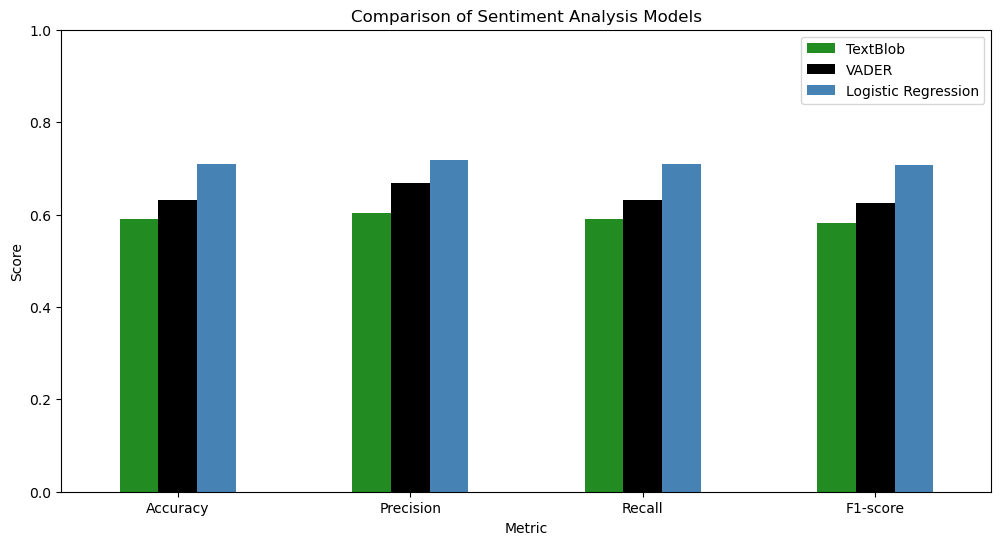

In [46]:
results_df.T.plot(kind='bar', figsize=(12, 6), color=['forestgreen','black','steelblue'])

plt.title('Comparison of Sentiment Analysis Models')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

Visualizing the distribution of the classification values would help us assess the confidence with which the differend models made their predictions.

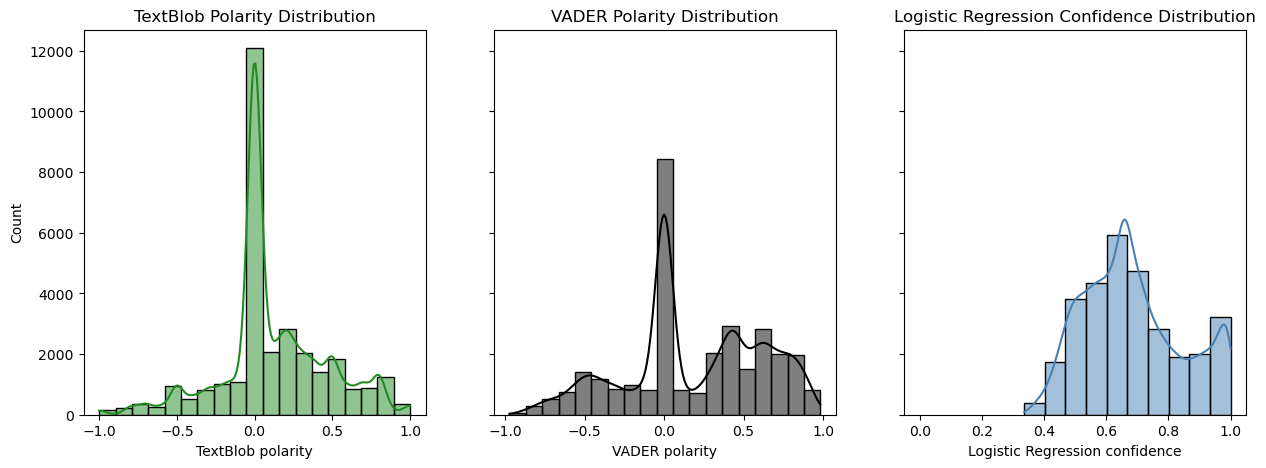

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.histplot(df['TextBlob polarity'], bins=19, kde=True, ax=axes[0], color='forestgreen')
axes[0].set_title('TextBlob Polarity Distribution')

sns.histplot(df['VADER polarity'], bins=19, kde=True, ax=axes[1], color='black')
axes[1].set_title('VADER Polarity Distribution')

sns.histplot(df['Logistic Regression confidence'], bins=10, kde=True, ax=axes[2], color='steelblue')
axes[2].set_title('Logistic Regression Confidence Distribution')
axes[2].set_xlim(-0.05, 1.05) 

plt.show()

Finally, we plot the confusion matrix for the 2 pre-trained models. We could throw in a third one for Logistic Regression but that wouldn't exactly be comparable.

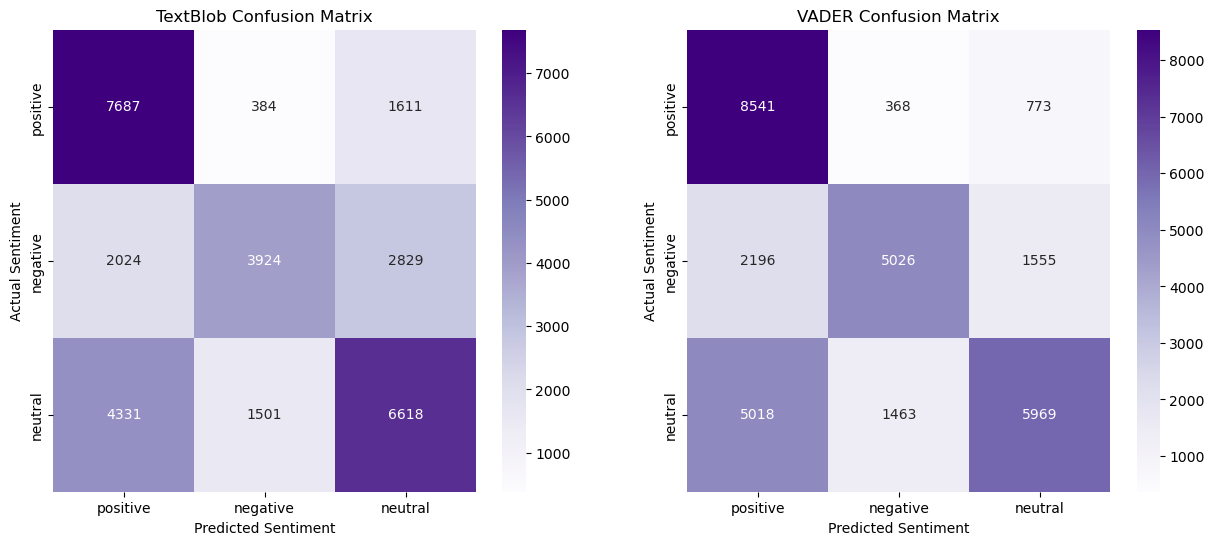

In [50]:
models.pop() # Logistic Regression
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i, model in enumerate(models):
    Y_pred = df[model]
    cm = confusion_matrix(Y, Y_pred, labels=['positive', 'negative', 'neutral'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'], ax=axes[i])
    axes[i].set_xlabel('Predicted Sentiment')
    axes[i].set_ylabel('Actual Sentiment')
    axes[i].set_title(model + ' Confusion Matrix')
plt.show()

Actually it would be interesting to inspect which texts none of the three models could correctly predict, despite aggreeing with each other, for further insights. Especially interesting are the non-neutral cases.

In [52]:
agreed_prediction = (df['TextBlob'] == df['VADER']) & (df['VADER'] == df['Logistic Regression'])
wrong_prediction = (df['TextBlob'] != df['sentiment'])
nonneutral_prediction = (df['sentiment'] != 'neutral') & (df['TextBlob'] != 'neutral')

interesting = df[agreed_prediction & wrong_prediction & nonneutral_prediction]

interesting[['dirty_text', 'text', 'sentiment', 'TextBlob', 'VADER', 'Logistic Regression']]

,dirty_text,text,sentiment,TextBlob,VADER,Logistic Regression
76,"WOW, i AM REALLY MiSSiN THE FAM(iLY) TODAY. BADDD.",wow really missin fam ily today baddd,negative,positive,positive,positive
103,i realy wanted to go out cause its so nice but everybodys busy,realy wanted go cause nice everybodys busy,negative,positive,positive,positive
139,"missed all the awesome weather, because she was in a movie!",missed awesome weather movie,negative,positive,positive,positive
369,l`m on 3 days too matt. No fun this weekend.,l days matt fun weekend,negative,positive,positive,positive
381,I`m 25 in december that`s not good at all next big birthday is 30 after 21 it flys by for sure,december good next big birthday flys sure,negative,positive,positive,positive
...,...,...,...,...,...,...
3194,"_fan76 ROFL! THAT`S my problem, only two hands",fan rofl problem two hands,negative,positive,positive,positive
3217,"I forgot that was tonight! Was planning on heading down to the Cask, that might not be such a good idea",forgot tonight planning heading cask might good idea,negative,positive,positive,positive
3428,"I`m mo nudge you again, better watch out!",mo nudge better watch,negative,positive,positive,positive
3429,HOW COME ITS SO HARD TO FIND A GUY WITH THE SAME PASSION FOR LOVE AS FOR A WOMAN?? AM I EVER GOING TO SEE THE DAY! IM lonely yall!,come hard find guy passion love woman ever going see day lonely yall,negative,positive,positive,positive


Obviously, there are hundreds of other things we could do. But for now let's leave it at that, I'm sure no professor would enjoy a more lengthy assignment to grade.

## Final Thoughts

As far as TextBlob and VADER are concerned, VADER seems to be marginally better for this dataset. The Achilles Heel of them both seems to be that they flag a lot of the neutral posts as positive. Of course, even the most basic "real" classifier easily outperforms both.

Overall, the models' confidence is fairly low, with many polarities being observed at or near zero, with Logistic Regression having a higher mean confidence of about 70%. Models also seem to be more confident in classifying positive sentiments.

We notice some misclassifications due to stopword removal, especially when negative words like "not" are removed, inversing the sentiment. I hope I learn more about that next semester with NLP?

The word "work" seems to be prevelant in negative sentiment texts. Imagine that.